In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import torch
seed = 42


random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from scipy.stats import norm, multivariate_normal, gaussian_kde
from scipy.integrate import nquad
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


In [ ]:
from mixture_lower import *
from value_estimator import *
from so_guidance import SecondOrderLinearizedDiffusion

In [7]:
B = 4
def reward_func(x, means, var, goodmeans, r = 1): #assumes all mixtures have same covariance matrix
    return r * np.linalg.norm((x - 7.5)/1000)**2
def reward_func_vectorized(x, means = None, var = None, goodmeans = None, r=1):
    return r * np.square(x[..., 0] -7.5)


def reward_func(x):
    """
    Hard step function for 2D input.
    Returns B when x[..., 0] < -7, and 0 otherwise.
    """
    x0 = np.asarray(x)[..., 0]
    return np.where(x0 < -7, B, 0)

In [4]:
n = T = 50
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta

In [35]:
# Monte Carlo parameters
num_trials =1 # Number of Monte Carlo trials
n_epochs = 10
num_training_trials = 10_000
# First loop: Train and store val_ensembles and reward_ests
val_ensembles = []
reward_ests = []
num_trials = 1

for trial in range(num_trials):
    print(f"Training Trial {trial + 1}/{num_trials}")

    # Fix random seed for reproducibility
    np.random.seed(trial)  # Use trial index as seed

    # Initialize random mixture means in [-1,1]^d
    mu_0 = np.array([[5, 0], [-5, 0]])

    # Shared covariance matrix
    var_0 = np.eye(d)

    # Mixture weights (normalized)
    pi_0 = np.array([0.95, 0.05])
    pi_0 /= np.sum(pi_0)

    # Initialize diffusion process
    dist0 = Mixture(mu_0, var_0, pi_0)
    diffusion = Diffusion(dist0, alpha_t, S = num_training_trials)

    X = diffusion.calc_samples()
    expr = np.exp(reward_func(X[:, -1, :]))

    # Train value ensemble
    val_ensemble = ValueEstimate(X, expr, [128, 256, 64])
    val_ensemble.train(epochs=n_epochs, verbose=False)
    val_ensembles.append(val_ensemble)


# val_ensembles = val_ensembles + [val_ensembles[0]]*(num_trials-1)
# reward_ests = reward_ests + [reward_ests[0]]*(num_trials-1)

# Second loop: Roll out trajectories using trained ensembles


Training Trial 1/1


Reverse Diffusion Progress: 100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


Building ValueEstimate...


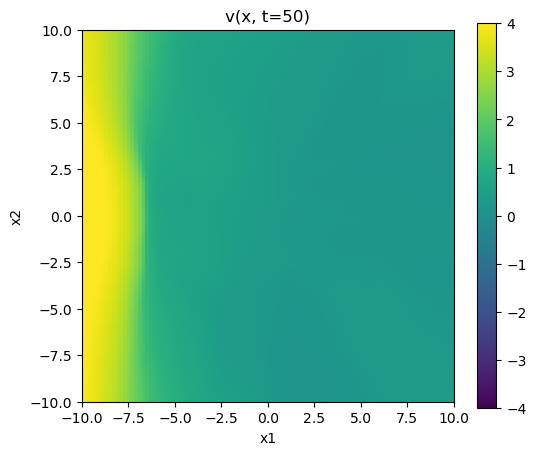

In [36]:
from matplotlib import animation

# Create a grid of x values
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)
grid_x = np.stack([xx1.ravel(), xx2.ravel()], axis=1)

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(np.zeros_like(xx1), extent=[-10, 10, -10, 10], origin='lower', vmin=-B, vmax=B)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('v(x, t) over time')
cb = fig.colorbar(cax)

t_vals = list(range(1, n + 1))

def animate(t_idx):
    t = t_vals[t_idx]
    t_arr = np.full((grid_x.shape[0],), t)
    v = val_ensemble.predict_under_log(grid_x, t_arr)
    v = np.squeeze(v)
    v_img = v.reshape(xx1.shape)
    cax.set_data(v_img)
    ax.set_title(f'v(x, t={t})')
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=True)
ani.save('v_under_log_over_time_differentiable_.gif', writer='pillow', fps=2)
plt.show()

In [ ]:
# torch.save(val_ensemble.state_dict(), "value_estimate_diff_objective.pt")

In [37]:
guided_steps_per = []  # Store guided.num_steps for each trial
guided_steps_mixed = []
guided_steps_last = []  # Store guided.num_steps for each trial

from so_guidance import SecondOrderGUidedDiffusion
X_guided = np.zeros((0, 2))
# X_last = np.zeros((0, 2))

num_trials = 1

for trial in range(num_trials):
    print(f"Rolling out Trial {trial + 1}/{num_trials}")

    val_ensemble = val_ensembles[trial]

    # Perform per-step guided diffusion
    quad_guided = SecondOrderGUidedDiffusion(dist0, alpha_t, val_ensemble, S = 200)

    def eval(x, t):
        o = np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))
        if o.ndim > 1:
            return np.squeeze(o, axis=2)
        else:
            return np.squeeze(o)

    guided_true = LastStepDiffusion(dist0, alpha_t, lambda x: np.log(np.clip(reward_func_vectorized(x, mu_0, var_0, [1], B), np.e**(-B), np.e**B)), upper_bound=B, temperature=1, S=200)

    X_guided = quad_guided.calc_samples()
    # X_guided_last = guided_true.calc_samples()

    # Concatenate results
    X_guided = np.concatenate((X_linear, X_guided[:, -1, :]), axis=0)
    # X_last = np.concatenate((X_last, X_guided_last[:, -1, :]), axis=0)



Rolling out Trial 1/1


Second-order reverse: 100%|██████████| 49/49 [00:06<00:00,  7.10it/s]


In [106]:
guided_steps_mixed

[33794, 34037, 36714, 32962, 31532]

In [75]:
# Compute Monte Carlo estimate
mean_steps_per = np.mean(guided_steps_per)
std_steps_per = np.std(guided_steps_per)

mean_steps_last = np.mean(guided_steps_last)
std_steps_last = np.std(guided_steps_last)

mean_steps_mixed = np.mean(guided_steps_mixed)
std_steps_mixed = np.std(guided_steps_mixed)

In [76]:
print(f"Monte Carlo estimate of guided.num_steps (per-step): {mean_steps_per:.2f} ± {std_steps_per:.2f} (std dev)")
print(f"Monte Carlo estimate of guided.num_steps (mixed): {mean_steps_mixed:.2f} ± {std_steps_mixed:.2f} (std dev)")
print(f"Monte Carlo estimate of guided.num_steps (last-step): {mean_steps_last:.2f} ± {std_steps_last:.2f} (std dev)")

Monte Carlo estimate of guided.num_steps (per-step): 23069.80 ± 2643.18 (std dev)
Monte Carlo estimate of guided.num_steps (mixed): 33807.80 ± 1696.67 (std dev)
Monte Carlo estimate of guided.num_steps (last-step): 29545.80 ± 1514.75 (std dev)


In [33]:
guided_last = LastStepDiffusion(dist0, alpha_t, lambda x: val_ensemble.predict_under_log(T, x), upper_bound=B, S=5000)
X_guided_last = guided_true.calc_samples()

Generating Trajectories: 218it [00:00, 270.06it/s]                         


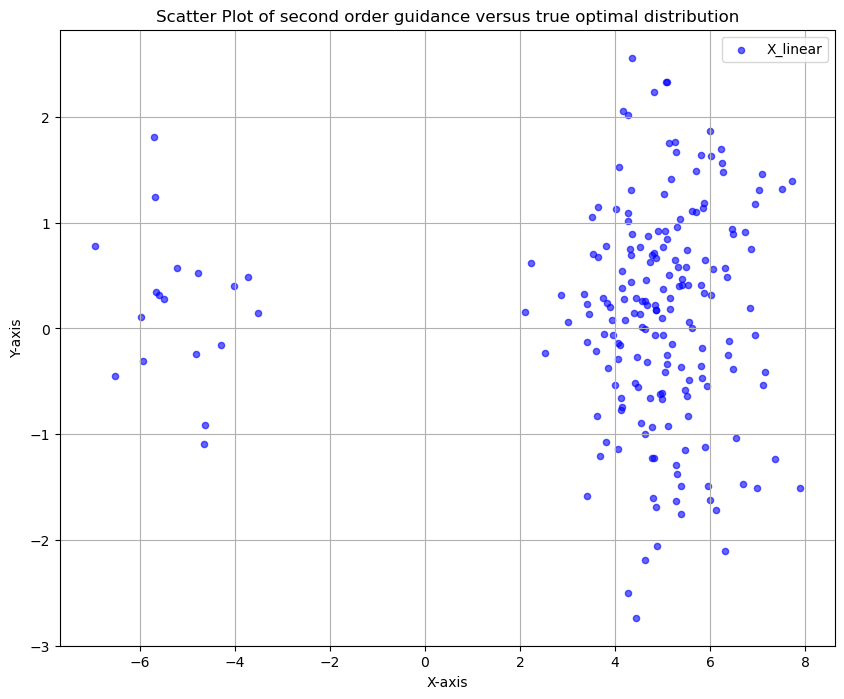

In [ ]:
plt.figure(figsize=(10, 8))

# Scatter plot for X_per
plt.scatter(X_guided[:, 0], X_guided[:, 1], label='X_linear', alpha=0.6, s=20, c='blue')
plt.scatter(X_guided_last[:, -1, 0], X_guided_last[:, -1, 1], label='X_last', alpha=0.6, s=20, c='red')



# Add labels, legend, and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of second order guidance versus true optimal distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

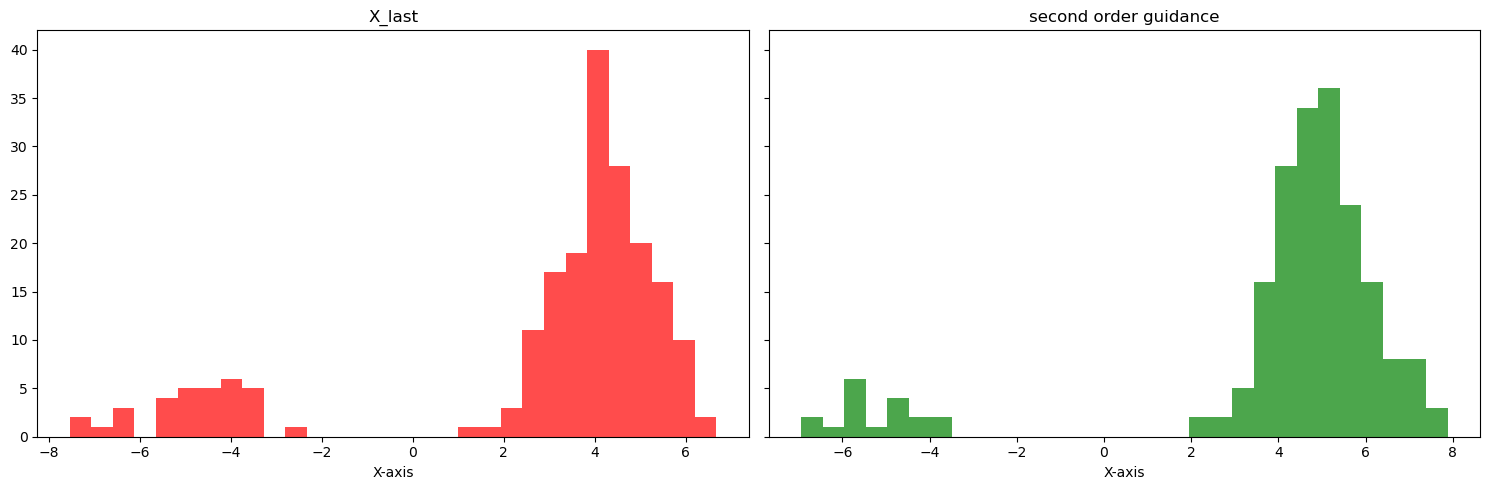

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)



# Histogram for X_per
axes[1].hist(X_guided[:, 0], bins=30, color='green', alpha=0.7)
axes[1].set_title('second order guidance')
axes[1].set_xlabel('X-axis')

# Histogram for X_last
axes[0].hist(X_guided_last[:,-1, 0], bins=30, color='red', alpha=0.7)
axes[0].set_title('X_last')
axes[0].set_xlabel('X-axis')




plt.tight_layout()
plt.show()

Approximate KL divergence (X_per || X_true): 0.9118 ± 4.5534
[0.9117723529672347]


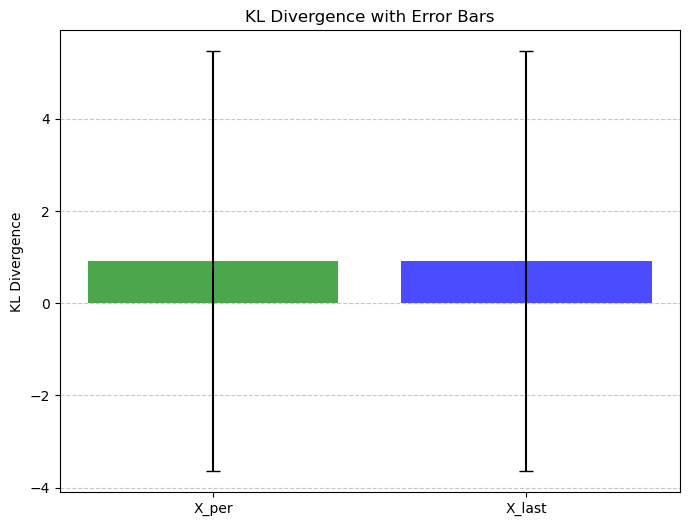

In [27]:
# Calculate KL divergence and standard deviation for X_per
p_kde_per = gaussian_kde(X_linear.T)
X_true = X_last
q_kde = gaussian_kde(X_true.T)

p_vals_per = p_kde_per(X_linear.T)
q_vals_per = q_kde(X_linear.T)
kl_div_per = np.mean(np.log(p_vals_per / q_vals_per))
std_kl_div_per = np.std(np.log(p_vals_per / q_vals_per))
print(f"Approximate KL divergence (X_per || X_true): {kl_div_per:.4f} ± {std_kl_div_per:.4f}")


# Plot the KL divergence with error bars
kl_divs = [kl_div_per]
print(kl_divs)
std_kl_divs = [std_kl_div_per]
labels = ['X_per', 'X_last']

plt.figure(figsize=(8, 6))
plt.bar(labels, kl_divs, yerr=std_kl_divs, capsize=5, color=['green', 'blue', 'red'], alpha=0.7)
plt.ylabel('KL Divergence')
plt.title('KL Divergence with Error Bars')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [105]:
kde_per = gaussian_kde(X_per.T)
kde_mixed = gaussian_kde(X_mixed.T)
kde_last = gaussian_kde(X_last.T)
kde_true = gaussian_kde(X_true.T)

# Define a grid for evaluation
grid_x, grid_y = np.meshgrid(
    np.linspace(-15, 15, 100),
    np.linspace(-15, 15, 100)
)
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()])

# Evaluate the PDFs on the grid
pdf_per = kde_per(grid_points)
pdf_mixed = kde_mixed(grid_points)
pdf_last = kde_last(grid_points)
pdf_true = kde_true(grid_points)

# Compute total variation distances
tv_per = 0.5 * np.sum(np.abs(pdf_per - pdf_true)) * (30 / 100) ** 2
tv_mixed = 0.5 * np.sum(np.abs(pdf_mixed - pdf_true)) * (30 / 100) ** 2
tv_last = 0.5 * np.sum(np.abs(pdf_last - pdf_true)) * (30 / 100) ** 2

print(f"Total Variation (X_per, X_true): {tv_per:.4f}")
print(f"Total Variation (X_mixed, X_true): {tv_mixed:.4f}")
print(f"Total Variation (X_last, X_true): {tv_last:.4f}")

Total Variation (X_per, X_true): 0.5908
Total Variation (X_mixed, X_true): 0.4334
Total Variation (X_last, X_true): 0.7985
